# Manually Build a Receiver Calibration for EDGES-2

In this demo, we will reproduce the calibration used in the "H2" case from [Bowman+2018](https://www.nature.com/articles/nature25792) from scratch.
There are a few ways you can do this. 

The easiest way is to use the "[alanmode](https://edges-analysis.readthedocs.io/en/stable/reference/alanmode.html)" sub-module, which is purpose-built to reproduce the legacy pipeline with minimal options to change the way that the calibration runs. See the [alanmode tutorial](https://edges-analysis.readthedocs.io/en/stable/demos/using_alanmod_b18.html) for a quick run-down on how to achieve this. 

As noted in that tutorial, `edges.alanmode` is not the recommended way of using the `edges` package, and doesn't provide access to the full functionality. Using the full functionality requires building an [`edges.cal.CalibrationObservation`](https://edges-analysis.readthedocs.io/en/stable/reference/_autosummary/edges.cal.calobs.html#module-edges.cal.calobs) directly, constructed from observations of reflection coefficients from different components of the system, calibration spectra, and measurements of the temperatures of each calibration source.

To build a full `CalibrationObservation`, it is generally recommended to use the [`CalibrationObservation.from_edges2_caldef`](https://edges-analysis.readthedocs.io/en/stable/reference/_autosummary/edges.cal.calobs.html#edges.cal.calobs.CalibrationObservation.from_edges2_caldef) method, which takes in a "calibration observation definition" object (i.e. a `edges.io.CalObsDefEDGES2` object) that defines where all the files containing observations are, and also many options that affect how these files are read and processed and combined. This exposes *almost* all the functionality of `edges.cal`, but can be a little restrictive in a couple of ways:

1. Sometimes observation files might not be neatly ordered on disk in a way that makes it easy to create the `CalObsDefEDGES2` (or EDGES3) object.
2. The set of processing functions that are invoked by `from_edges2_caldef` are quite flexible, but not exhaustive. There might be use-cases that require manual processing of parts of the data before combining them all into the `CalibrationObservation`.
3. The `CalibrationObservation` that is returned from `from_edges2_caldef` doesn't hold references to many of the intermediate products that get created along the way. This is usually fine (these intermediates not being essential for determining the final calibration parameters) but in certain cases you might want to inspect these, and there is no real chance to do so when you make the object in a single command.

In this demo, we will manually construct the `CalibrationObservation` by building each component in turn, and we will do this for the Bowman+2018 data for which we have a legacy pipeline that we would like to match.
Constructing the observation manually thus gives us a chance to verify that each component matches the legacy pipeline as we go, as well as giving a chance to explain the purpose of each component. Note that we will 
still use many convenience functions that mean we don't have to perform *all* the steps manually, but we will have direct access to all of the main intermediary products.

## Imports

In [1]:
from pathlib import Path
import numpy as np

from astropy import units as un
import yaml
import matplotlib.pyplot as plt

# Import the 'io' module which has classes
# that represent collections of files used to calibrate
# certain components.
from edges import io

# Import the 'data' module which has functions
# for downloading and caching the datasets we'll use here.
from edges import data as datatools

# Import the 'cal' module which defines functions and classes
# useful for receiver calibration.
from edges import cal

# Import the `cal.sparams` module specifically, because
# it has a lot of methods for calibrating reflection coefficients.
from edges.cal import sparams as sp

# Import the alanmode module, merely for reading 
# data produced by the legacy pipeline, so we can compare.
from edges import alanmode as legacyio


## Get Required Data

First, let's fetch the raw calibration data we'll need to construct the calibration observation in this demo. This is exactly the raw data that went into the calibration of Bowman+2018. The first time you run this, it will take a while to fetch the >2.5 GB of spectra.

In [2]:
s11root = Path("reformatted")  # NOTE: update once we upload the new S11s.
specroot = datatools.fetch_b18cal_spectra()
thermroot = datatools.fetch_b18cal_resistances()

Let's also now read in the legacy results that we will later compare to:

In [66]:
legacy_dir = datatools.fetch_b18_cal_outputs() / 'H2Case-fittpfix'

legacy_raw_s11s = legacyio.read_raul_s11_format(datatools.fetch_b18cal_calibrated_s11s())
legacy_mdl_s11s = legacyio.read_modelled_s11s(legacy_dir / 's11_modelled.txt')
_, legacy_spec = legacyio.read_all_spec_txt(legacy_dir, flow=50*un.MHz, fhigh=100*un.MHz)
legacy_hot_load_loss = np.genfromtxt(legacy_dir / "hot_load_loss.txt")
legacy_calibrator = legacyio.read_specal(legacy_dir / 'specal.txt', t_load=300.0, t_load_ns=1000.0)

## Reflection Coefficients

We will first read and calibrate the reflection coefficient measurements for different components of the receiver and calibration inputs. Throughout this section we will refer to the following figure (which also appears in Murray+2025), which defines the components of the receiver system in the way we will refer to them in this document:

<div>
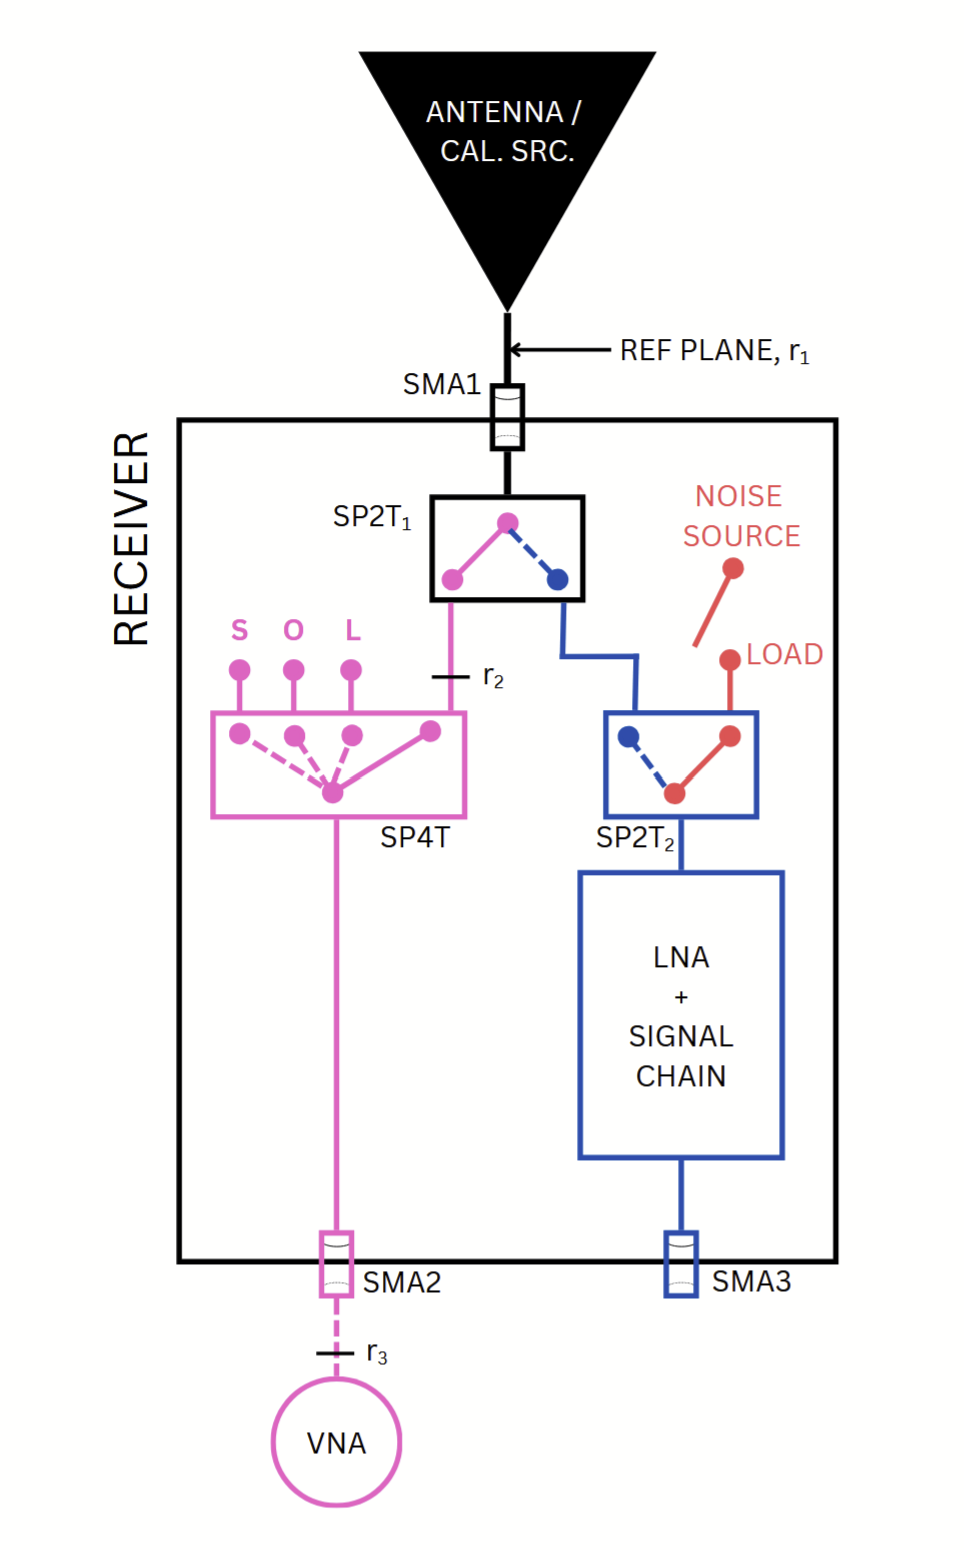
</div>

**Figure 1 | The EDGES-2 Receiver System**.

One important thing is that throughout, the legacy calibration used an offset delay for the match calkit standard (for the AGILENT_85033E) of 30 picoseconds, which needs to be 
manually specified every time this calkit is used (its default is 38 picoseconds in `edges.cal`):

In [4]:
CALKITKW = {"match": {"offset_delay": 30*un.picosecond}}

### Receiver S11

The first important measurements to calibrate are those of the receiver's reflection coefficient. The 'receiver' here is the "blue" path in Figure 1. It is measured by 
connecting a VNA (in the lab) to the SMA1 input, and terminating SMA3 with an open calkit standard (approximating infinite resistance). That forms one measurement
(called the "device" measurment). However, this is not quite calibrated to the correct reference plane ($r_1$). To calibrate the measurement, we use three $S_{11}$ 
measurements---one each for the three standards in an OSL "Calkit". These are plugged in directly to the VNA itself (we're just trying to calibrate out the tiny 
connector in the VNA to get to the correct reference plane). 

We can define these measurements in a `ReceiverS11` "definition" object, which just holds references to the files in which the measurements are stored, and we can
then use that object to actually read and perform the calibration. However, for this work we made these four measurments a total of 6 times each, in order to average down
the results and end up with lower noise:

In [5]:
lna_paths = sorted(s11root.glob("ReceiverReading*"))

def get_lna_filespec(d: Path):
    calkit = io.CalkitFileSpec(
        open = d / 'open.s1p',
        short = d / 'short.s1p',
        match = d / 'load.s1p',
    )
    return io.ReceiverS11(calkit=calkit, device=d / 'LNA.s1p')

In [6]:
lna_filespecs = [get_lna_filespec(d) for d in lna_paths]

Let's read and calibrate each in turn (Note that we pass the `calkit_overrides` argument here to over-write the assumed delay of the match offset (by default it is 38 picoseconds):

In [7]:
all_gamma_rcv = [sp.get_gamma_receiver_from_filespec(lna, calkit_overrides=CALKITKW) for lna in lna_filespecs]

However, we can also just pass the entire list of filespec's and it will average them for us:

In [8]:
gamma_rcv = sp.get_gamma_receiver_from_filespec(lna_filespecs, calkit_overrides=CALKITKW)

The returned object is a `ReflectionCoefficient` object:

In [9]:
type(gamma_rcv)

edges.cal.sparams.core.datatypes.ReflectionCoefficient

which simply holds two arrays: the frequencies and the reflection coefficient itself:

Text(0.5, 1.0, 'Did we match B18?')

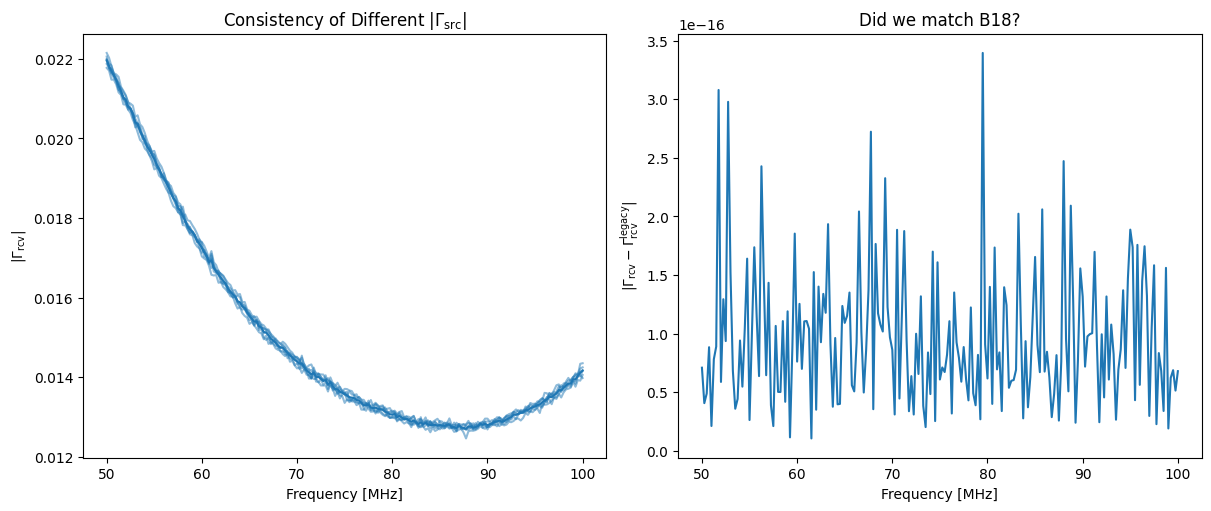

In [13]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 5), constrained_layout=True)


for gamma in all_gamma_rcv:
    ax[0].plot(gamma.freqs.to_value("MHz"), np.abs(gamma.reflection_coefficient), color='C0', alpha=0.5)
    
ax[0].plot(gamma.freqs.to_value("MHz"), np.abs(gamma_rcv.reflection_coefficient), color='C0')
ax[1].plot(gamma_rcv.freqs.to_value("MHz"), np.abs(gamma_rcv.reflection_coefficient - legacy_raw_s11s['lna']))

ax[0].set_xlabel("Frequency [MHz]")
ax[1].set_xlabel("Frequency [MHz]")
   
ax[0].set_ylabel(r"$|\Gamma_{\rm rcv}|$")
ax[1].set_ylabel(r"$|\Gamma_{\rm rcv} - \Gamma^{\rm legacy}_{\rm rcv}|$")

ax[0].set_title(r"Consistency of Different $|\Gamma_{\rm src}|$")
ax[1].set_title("Did we match B18?")

### Internal Switch S-parameters 

Now let's calculate the S-parameters of the internal switch (i.e. the SP2T1 + SMA1 in Figure 1, or equivalently the subsystem between $r_1$ and $r_2$). 

This uses two sets of calkit measurments, both measured by a VNA plugged into SMA3. The first set is the *internal* OSL standards attached to the SP4T. These are used to get the S-parameters of the subsystem joining $r_3$ to $r_2$. The second set is the *external* OSL standards which get plugged in at SMA1 in place of the input source. We use the SP4T $S$-parameters to re-reference each of these external measurements to $r_2$, and then use these re-referenced OSL measurements to calculate the S-parameters of $r_1 r_2$.

This measurement is done in the lab, and then used not only in the receiver calibration, but also in calibrating the antenna measurements in the field. Since the S-parameters are likely to be dependent on temperature, we performed the measurement at three different temperatures and we linearly interpolate between them given the temperature of any particular measurement.

First, let's define the set of files we need:

In [15]:
def get_switch_state_filespec(d: Path):
    return io.InternalSwitch(
        internal = io.CalkitFileSpec(
            open = d / 'open.S1P',
            short = d/ 'short.S1P',
            match = d/ 'load.S1P',
        ),
        external = io.CalkitFileSpec(
            open = d / 'open_input.S1P',
            short = d/ 'short_input.S1P',
            match = d/ 'load_input.S1P',
        ),
    )

In [16]:
internal_switch_paths = sorted((s11root / "InternalSwitch").glob("*degC"))
internal_switch_filespecs = [get_switch_state_filespec(d) for d in internal_switch_paths]

Note that again, the calkit model and the resistance of the match standard as measured during the calibration setup is recorded in the `metadata.yaml` file that sits alongside
these files, and this is automatically picked up by the `InternalSwitch` object.

Now, when we go to convert these files into calibrated internal switch S-parameters, we must remember to over-ride the calkit with the assumed delay in offset (using `CALKITKW` as above), and also to specify the ambient temperature at which the calibration was run (here it was 27 degrees):

In [17]:
internal_switch = sp.get_internal_switch_from_caldef(internal_switch_filespecs, calkit_overrides=CALKITKW, measured_temperature=27.0*un.deg_C)

The internal switch S-params we currently have are noisy measurements. but we don't expect the true S-params to be noisy. So we fit a model to the measurements
before using them to calibrate the calibration source reflection parameters (next). To do this, we need to define the parameters of a model that will be used.
Luckily, we can specify all of these simply by using a set of defaults (this is one of those convenience methods we mentioned earlier -- you can also control
the modeling here by passing a `model` keyword as well as specifying whether you want to fit the real/imag components or the amp/phase components. The full set
of parameters you can set are:

In [22]:
print(sp.S11ModelParams.__doc__)

A class holding parameters required to model an S11.


In [23]:
intsw_model_params = sp.internal_switch_model_params()

Now, let's smooth the s-parameters, which we can do simply with the `.smoothed` method. Note that we don't pass any frequencies to smooth onto, because here we're just smoothing back onto 
the same frequencies:

In [25]:
internal_switch_smooth = internal_switch.smoothed(params=intsw_model_params)

We can evaluate whether our smoothing model was a good fit to the data:

Text(0.5, 0.98, 'Accuracy of Internal Switch smoothing')

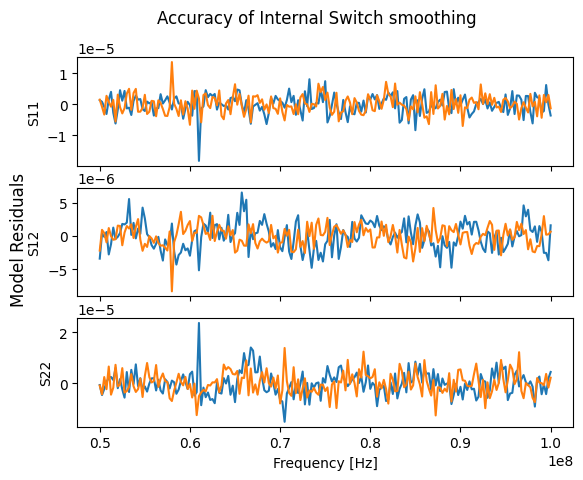

In [33]:
fig, ax = plt.subplots(3, 1, sharex=True)


ax[0].plot(internal_switch.freqs, internal_switch.s11.real - internal_switch_smooth.s11.real)
ax[0].plot(internal_switch.freqs, internal_switch.s11.imag - internal_switch_smooth.s11.imag)

ax[1].plot(internal_switch.freqs, internal_switch.s12.real - internal_switch_smooth.s12.real)
ax[1].plot(internal_switch.freqs, internal_switch.s12.imag - internal_switch_smooth.s12.imag)

ax[2].plot(internal_switch.freqs, internal_switch.s22.real - internal_switch_smooth.s22.real)
ax[2].plot(internal_switch.freqs, internal_switch.s22.imag - internal_switch_smooth.s22.imag)

ax[2].set_xlabel(f"Frequency [{internal_switch.freqs.unit}]")
ax[0].set_ylabel("S11")
ax[1].set_ylabel("S12")
ax[2].set_ylabel("S22")

fig.supylabel("Model Residuals")
fig.suptitle("Accuracy of Internal Switch smoothing")

We notice that There is some residual structure here in the S12, and so it may require a more flexible model. Nevertheless, exploring that is not in the scope of this demo!

### Calibration Loads

Now we move to obtain the reflection coefficients of the calibration loads. First we define a mapping between what we'll call each of the calibration
loads in our code, to the name of the sources as they appear in filenames:

In [34]:
source_name_map = {
    'open': "LongCableOpen",
    "short": "LongCableShorted",
    "ambient": "Ambient",
    "hot_load": "HotLoad",
}

The source reflection coefficients require two sets of measurements: the measurement of the (uncalibrated) S11 of the input source with the VNA plugged in at SMA3, and a
set of measurements of the *internal* OSL standards. Together with the known S-parameters of the internal switch, this can calibrate the S11 measurement back to the $r_1$ 
reference plane:

In [38]:
def get_source_filespec(d: Path):
    # Internal calkit measurements
    calkit = io.CalkitFileSpec(
        open = d / 'open.S1P',
        short = d / 'short.S1P',
        match = d / 'load.S1P',
    )
    
    # Measurement of the external source plugged in at the input (SMA1)
    external = next(iter(d.glob("*_input.S1P")))
    
    return io.LoadS11(calkit=calkit, external=external)


In [37]:
source_filespecs = {name: get_source_filespec(s11root/fname) for name, fname in source_name_map.items()}

Again, we use a convenience function to read and calibrate the source reflection coefficients, passing in the (smoothed) S-parameters of the internal switch to do that calibration:

In [39]:
gamma_src = {name: sp.get_gamma_src_from_filespec(fspec, internal_switch=internal_switch_smooth) for name, fspec in source_filespecs.items()}

Now we can make a plot of the S11's, and also their residual to both smoothing models, as well as to the original B18 data. First, let's compute the smoothed versions, using the convenience function for default model parameters of the input sources:

In [40]:
gamma_src_mdl = {name: gamma.smoothed(sp.input_source_model_params(name)) for name, gamma in gamma_src.items()}

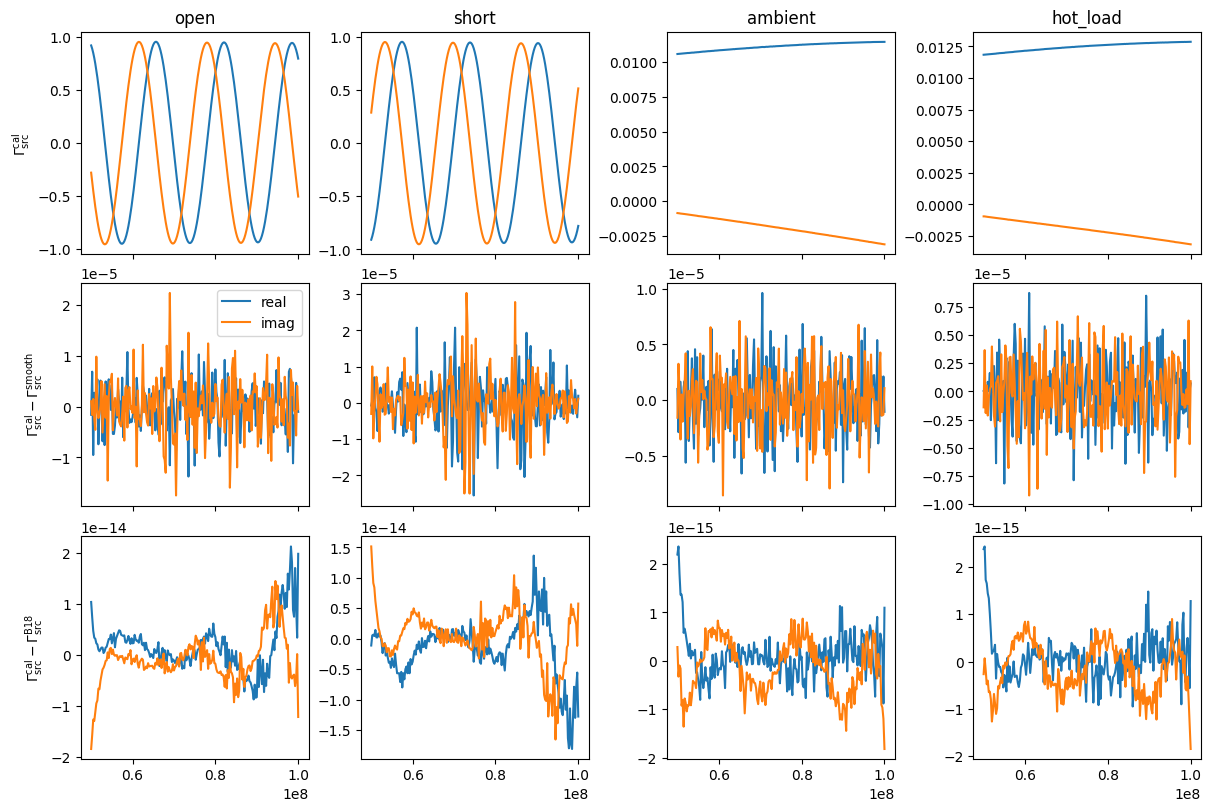

In [46]:
fig, ax = plt.subplots(3, 4, sharex=True, constrained_layout=True, figsize=(12, 8))

for i, (name, gamma) in enumerate(gamma_src.items()):
    oldname = 'amb' if name=='ambient' else 'hot' if name=='hot_load' else name
    
    ax.T[i, 0].plot(gamma.freqs, gamma.reflection_coefficient.real)
    ax.T[i, 0].plot(gamma.freqs, gamma.reflection_coefficient.imag)

    ax.T[i, 1].plot(gamma.freqs, gamma.reflection_coefficient.real - gamma_src_mdl[name].reflection_coefficient.real, label='real')
    ax.T[i, 1].plot(gamma.freqs, gamma.reflection_coefficient.imag - gamma_src_mdl[name].reflection_coefficient.imag, label='imag')
    
    ax.T[i, 2].plot(gamma.freqs, gamma.reflection_coefficient.real - legacy_raw_s11s[oldname].real)
    ax.T[i, 2].plot(gamma.freqs, gamma.reflection_coefficient.imag - legacy_raw_s11s[oldname].imag)
    
    ax.T[i, 0].set_title(name)

ax[0,0].set_ylabel(r"$\Gamma^{\rm cal}_{\rm src}$")
ax[1,0].set_ylabel(r"$\Gamma^{\rm cal}_{\rm src} - \Gamma_{\rm src}^{\rm smooth}$")
ax[2,0].set_ylabel(r"$\Gamma^{\rm cal}_{\rm src} - \Gamma_{\rm src}^{\rm B18}$")


ax[1, 0].legend()


### Hot Load Semi-Rigid Cable

The last set of S-parameters we need are those of the semi-rigid cable that attaches the hot load to the SMA1 input. These S-parameters are used later to compute
the loss over this cable. These S-params are simply measured with standard OSL calkit.

In [47]:
def get_semirigid_filespec(d: Path):
    return io.HotLoadSemiRigidCable(
        osl = io.CalkitFileSpec(
            open=d / 'open_sr_0dBm_500av.S1P',
            short=d / 'short_sr_0dBm_500av.S1P',
            match=d /'load_sr_REPETITION_2_0dBm_500av.S1P'
        )
    )

In [48]:
semirigid = sp.get_hot_load_semi_rigid_from_filespec(get_semirigid_filespec(s11root / 'SemiRigidCableHotLoad'), calkit_overrides=CALKITKW)

Let us again check how close these are to the legacy values:

Text(0.5, 1.0, 'Difference to legacy Semi Rigid Cable')

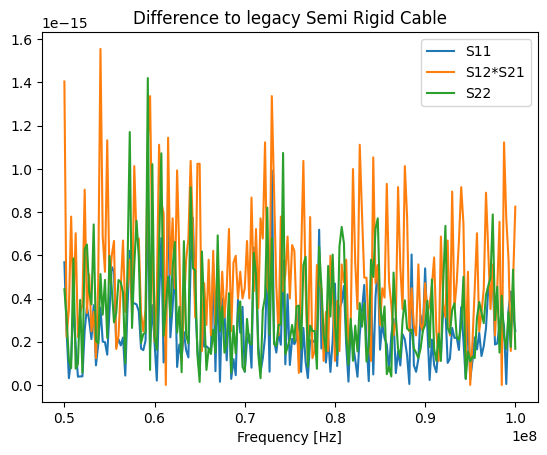

In [52]:
plt.plot(semirigid.freqs, np.abs(semirigid.s11 - legacy_raw_s11s['s11rig']), label='S11')
plt.plot(semirigid.freqs, np.abs(semirigid.s12**2 - legacy_raw_s11s['s12rig']), label='S12*S21')
plt.plot(semirigid.freqs, np.abs(semirigid.s22 - legacy_raw_s11s['s22rig']), label='S22')

plt.xlabel("Frequency [Hz]")
plt.legend()
plt.title("Difference to legacy Semi Rigid Cable")

## Calibration Spectra

Now let's turn to reading the spectra for each calibration source. We read the calibration spectra into a `LoadSpectrum` object with the [`from_loaddef` function](https://edges-analysis.readthedocs.io/en/stable/reference/_autosummary/edges.cal.spectra.html#edges.cal.spectra.LoadSpectrum.from_loaddef). This function has many options, and we only set a few below, in order to reproduce Bowman+2018. We will comment each to give a flavor of what's going on:

In [53]:
def get_source_spectra(source):
    specfiles = sorted(specroot.glob(f"{source_name_map[source]}*.acq"))
    thermistor = next(iter(thermroot.glob(f"{source_name_map[source]}*.csv")))
    
    return cal.LoadSpectrum.from_loaddef(
        specfiles=specfiles,    # the spectrum files to read
        load_name=source,       # name of the source
        thermistor=thermistor,  # the thermistor files defining the temperatures of the sources. NOT USED here...
        temperature=399*un.K if source=='hot_load' else 296*un.K,  # instead, explicit set the assumed temperature here.
        frequency_smoothing = "gauss",  # smooth the spectra with a gaussian convolutional filter
        freq_bin_size=8,                # then down-sample by eight channels
        f_low = 40.0 * un.MHz,          # before down-sampling, include only between 40-110 MHZ
        f_high = 110.0 * un.MHz,
        f_range_keep=(50.0*un.MHz, 100*un.MHz),  # after down-sampling, reduce the range to 50-100 MHz 
        ignore_times = 7200.0 * un.s,   # ignore the first 7200 sec of data, to allow warmup
        time_coordinate_swpos=2,        # when ignoring times, consider the time of the last switch-position
        cache_dir='spec-cache',  # cache the time-averaged spectrum here so next time we don't read the full spectra.
    )
    

In [54]:
source_spectra = {name: get_source_spectra(name) for name in source_name_map}

Now let's plot these spectra as a difference to the legacy pipeline:

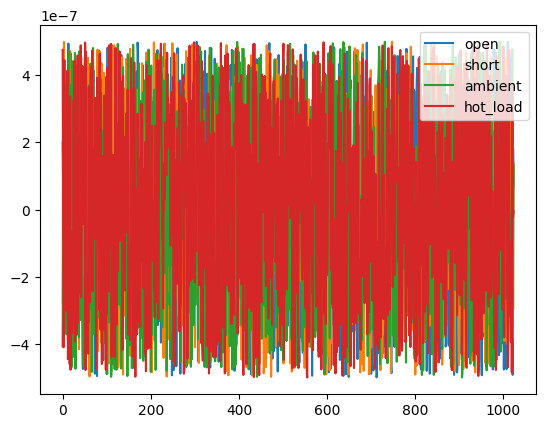

In [55]:
for name, spec in source_spectra.items():
    plt.plot(spec.averaged_q*1000 + 300 - legacy_spec[name], label=name)
plt.legend()

## Form the Calibration Observation

Now we have the S11's and spectra, we can combine them all into a full calibration observation.

The first thing to do is compile the information about each input source into an `InputSource` object. 
Most of the work here is simply smoothing the reflection coefficients and S-parameters on to the same grid as the spectrum. 
We do this in the same way we have seen before (using `.smoothed()`) but we also pass in the frequency channels of the
spectrum data to interpolate these models.

In [59]:
spec_freqs = source_spectra['open'].freqs

semirigid_smooth = semirigid.smoothed(params=sp.hot_load_cable_model_params(), freqs=spec_freqs)
gamma_src_smoothed = {name: gamma.smoothed(params=sp.input_source_model_params(name), freqs=spec_freqs) for name, gamma in gamma_src.items()}
gamma_rcv_smoothed = gamma_rcv.smoothed(freqs=spec_freqs, params=sp.receiver_model_params())

Now we define a small function that constructs each `InputSource` object. The only interesting thing here is that we also need to construct a model for the loss of the hot load, for which we use the `LossFunctiongivenSparams` object:

In [62]:
def get_input_sources(source: str):
    gamma = gamma_src_smoothed[source]
    
    # Construct the hot-load loss function
    if source=='hot_load':
        loss_model = cal.LossFunctionGivenSparams(semirigid_smooth)
        loss = loss_model(gamma)
    else:
        loss = np.ones(len(spec.freqs))
        
    
    return cal.InputSource(
        spectrum=source_spectra[source],
        reflection_coefficient=gamma,
        loss=loss,
        ambient_temperature=296*un.K,
        name=source,
    )

In [63]:
input_source_objs = {source: get_input_sources(source) for source in source_spectra}

Let's check that our hot load loss is matching the legacy pipeline. Note that the legacy pipeline outputs the hot load loss before constraining the bandwidth down to 50-100 MHz (though it only uses the loss *after* cutting down to this bandwidth, as we do), so we need to apply a mask in order to compare it:

Text(0.5, 1.0, 'Difference in hot load loss model')

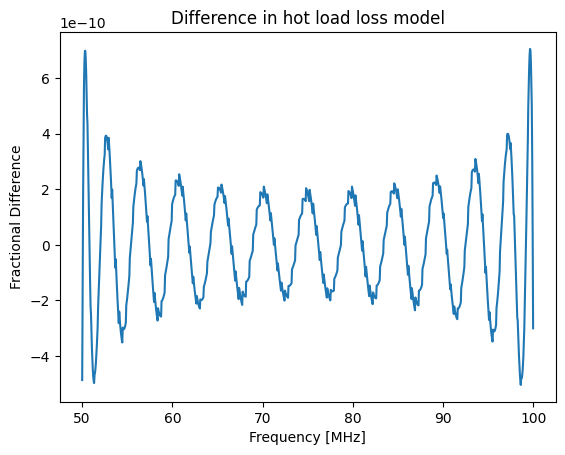

In [70]:
mask = (legacy_hot_load_loss[:, 0]>50.0) & (legacy_hot_load_loss[:, 0] <=100.0)

plt.plot(calobs.freqs, input_source_objs['hot_load'].loss / legacy_hot_load_loss[mask, 1] - 1)

plt.xlabel("Frequency [MHz]")
plt.ylabel("Fractional Difference")
plt.title("Difference in hot load loss model")

Now we can use these sources and and the receiver reflections to define a calibration observation:

In [65]:
calobs = cal.CalibrationObservation(loads=input_source_objs, receiver=gamma_rcv_smoothed)

Before going further, we do a final check that our *modelled* reflection coefficients all match those of the legacy pipeline:

In [71]:
legacy_s11m = legacy_mdl_s11s
mask = (legacy_s11m['freqs']>=50*un.MHz) & (legacy_s11m['freqs']<=100*un.MHz) 
legacy_s11m = legacy_s11m[mask]

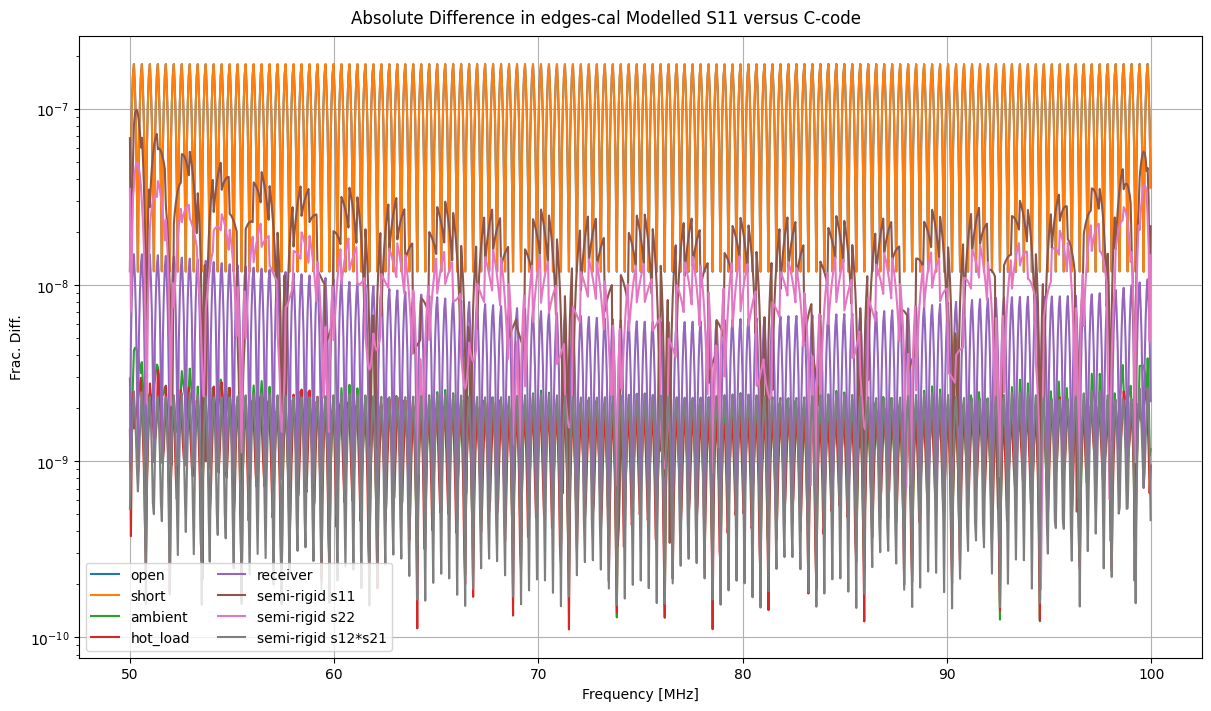

In [72]:
fig, ax = plt.subplots(1, 1, sharex=True, constrained_layout=True, figsize=(12, 7))

for i, (name, load) in enumerate(calobs.loads.items()):
    ax.plot(calobs.freqs, np.abs(load.s11.s11 - legacy_s11m[name])/np.abs(legacy_s11m[name]), label=name)
    
ax.set_yscale('log')
ax.set_ylabel("Frac. Diff.")
        
# Also plot the semi-rigid and receiver S11's
ax.plot(calobs.freqs, np.abs(calobs.receiver.s11 - legacy_s11m['receiver'])/np.abs(legacy_s11m['receiver']), label='receiver')
sp = semirigid_smooth
ax.plot(calobs.freqs, np.abs(sp.s11 - legacy_s11m['semi_rigid s11'])/np.abs(legacy_s11m['semi_rigid s11']), label=f'semi-rigid s11')
ax.plot(calobs.freqs, np.abs(sp.s22 - legacy_s11m['semi_rigid s22'])/np.abs(legacy_s11m['semi_rigid s22']), label=f'semi-rigid s22')
ax.plot(calobs.freqs, np.abs(sp.s12**2 - legacy_s11m['semi_rigid s12'])/np.abs(legacy_s11m['semi_rigid s12']), label=f'semi-rigid s12*s21')
    
    
ax.legend(ncols=2)
ax.grid(True)
ax.set_xlabel("Frequency [MHz]")
fig.suptitle("Absolute Difference in edges-cal Modelled S11 versus C-code");

## Perform Iterative Noise-Wave Parameter Calibration

Now that we have the calibration observation, we can use the data in it to perform noise-wave parameter calibration. There
are several parameters that can be set in this calculation that define how this iterative procedure runs. Here we set only
those required to reproduce the legacy pipeline:

In [73]:
calibrator = cal.get_noise_wave_calibration_iterative(
    calobs,
    cterms=6,  # number of terms in the Toff/Tsca temperature models
    wterms=5,  # number of terms in the noise-wave temperature models
    apply_loss_to_true_temp=False,  # apply loss correction to hot-load *spectra*, not temperature
    smooth_scale_offset_within_loop=False,  # Only smooth Toff/Tsca after the full algorithm is done
    ncal_iter=8,  # use eight iterations
    cable_delay_sweep=np.arange(0, -1e-8, -1e-9),   # the delays to check when fitting the long cable data
    fit_method="lstsq",  # use lstsq fitting (most robust)
    scale_offset_poly_spacing=0.5,  # Toff/Tsca become a + bx^0.5 + cx + dx^1.5 etc
    t_load_guess=300 * un.K,     # initial guess for Tload and Tload+ns, should not affect results
    t_load_ns_guess=1000 *un.K,
)

Finally, we make a plot comparing the calibration parameters to the legacy code:

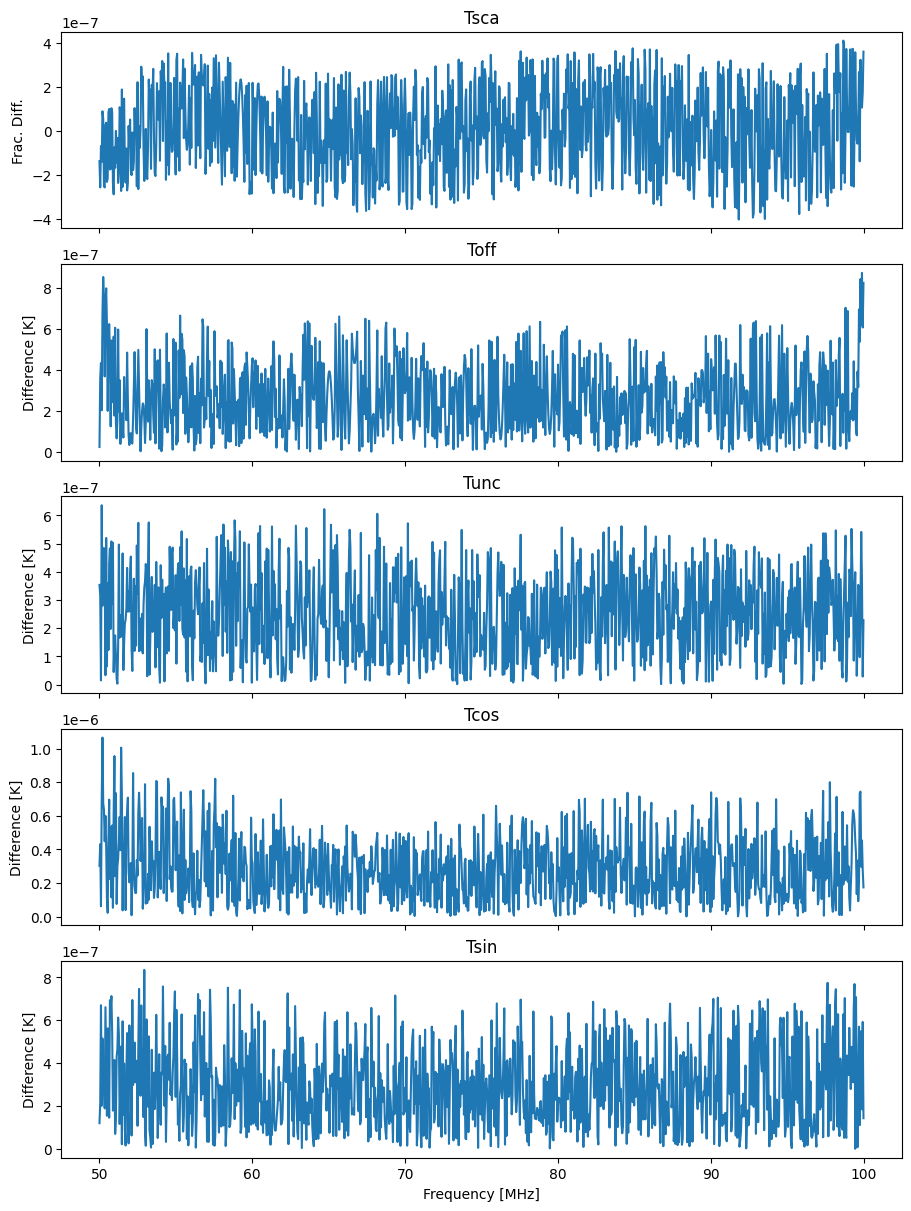

In [74]:
caltemps = ['Tsca', 'Toff', 'Tunc', 'Tcos', 'Tsin']

fig, ax = plt.subplots(len(caltemps), 1, sharex=True, constrained_layout=True, figsize=(9, 12))


for i, name in enumerate(caltemps):
    if name=='Tsca':
        # Scaling temperature, plot the ratio
        ax[i].plot(calobs.freqs, np.abs(getattr(calibrator, name) / getattr(legacy_calibrator, name)) - 1)
        ax[i].set_ylabel("Frac. Diff.")
    else:
        ax[i].plot(calobs.freqs, np.abs(getattr(calibrator, name) - getattr(legacy_calibrator, name)))
        ax[i].set_ylabel("Difference [K]")

    ax[i].set_title(name)
    
    
ax[-1].set_xlabel("Frequency [MHz]");